# Cart and Pole Deep Q-Network Project

## Import Libraries

Notice: The team that has been maintaining Gym has moved all future development to Gymnasium. The original Gym repo isn't planned to receive any future updates. All future updates to the API will be in the Gymnasium repo. Please install Gymnasium with the command below and import gymnasium as gym. This notebook has been updated to use Gymnasium.  

pip install gymnasium  

Reference: https://github.com/openai/gym#important-notice

In [1]:
%matplotlib inline
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Reproducibility  

Make reproducible results more likely by removing some of the variability of the randomness involved in the program. Results may still vary. See more:  
https://pytorch.org/docs/stable/notes/randomness.html

In [2]:
torch.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Set up display

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network

In [4]:
class DQN(nn.Module):
    def __init__(self, num_state_features):
        super().__init__()
         
        self.fc1 = nn.Linear(in_features=num_state_features, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)            

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience class

In [5]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [6]:
e = Experience(2,3,1,4)

## Replay Memory

In [7]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

In [8]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

## Reinforcement Learning Agent

In [9]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(self.device) # exploit

## Environment Manager

In [10]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped # use render_mode='human' for display (slows program)
        self.env.reset()
        self.done = False
        self.current_state = None
    
    def reset(self):
        self.current_state = self.env.reset()[0]
        
    def close(self):
        self.env.close()
        
    def render(self):
        return self.env.render()
        
    def num_actions_available(self):
        return self.env.action_space.n
        
    def take_action(self, action):        
        self.current_state, reward, self.done, _, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def get_state(self):
         if self.done:
            return torch.zeros_like(torch.tensor(self.current_state), device=self.device).float()
         else:
            return torch.tensor(self.current_state, device=self.device).float()
        
    def num_state_features(self):
        return self.env.observation_space.shape[0]

## Example of starting state

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
em.get_state()

tensor([ 0.0316, -0.0451, -0.0366, -0.0456], device='cuda:0')

## Example of non-starting state

In [12]:
for i in range(5):
    em.take_action(torch.tensor([1]))
state = em.get_state()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
em.get_state()

tensor([-0.0278,  0.0324, -0.0163,  0.0008], device='cuda:0')

## Example of end state

In [13]:
em.done = True
state = em.get_state()
state

tensor([0., 0., 0., 0.], device='cuda:0')

## Utility functions

### Plotting

In [14]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

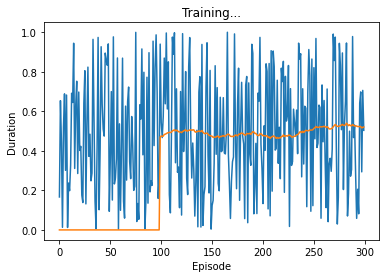

Episode 300 
 100 episode moving avg: 0.5206009


In [15]:
plot(np.random.rand(300), 100)

### Tensor processing

In [16]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.stack(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.stack(batch.next_state)

    return (t1,t2,t3,t4)

#### Example of Experience(\*zip(\*experiences)) used above
See https://stackoverflow.com/a/19343/3343043 for further explanation.

In [17]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [18]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

### Q-Value Calculator

In [19]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program

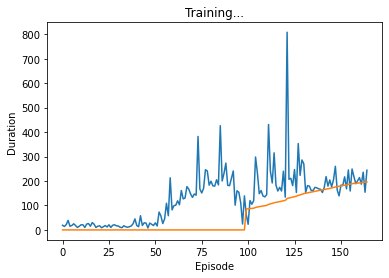

Episode 165 
 100 episode moving avg: 195.75


In [20]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.num_state_features()).to(device)
target_net = DQN(em.num_state_features()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    if get_moving_average(100, episode_durations)[-1] >= 195:
        break
        
em.close()

In [21]:
assert get_moving_average(100, episode_durations)[-1] > 15